In [280]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
from datetime import datetime
import scipy
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from IPython.display import clear_output
import shutil
%matplotlib inline

In [10]:
folder_path = '/Users/vovan/Desktop/University of Cambridge/Research/Data processing/Test data/' #enter test data folder pathway
folder_name = 'PST PEloops heating' #enter folder name

In [298]:
def create_dirs(folder_name): #sorts data and creates directories for processing
    
    directories = []
    
    #current date and time
    now = datetime.now()
    dt_string = now.strftime('%d.%m.%Y %H %M')
    
    data_folder_path = folder_path + folder_name + '/'
    
    filenames = glob.glob(data_folder_path + '*.tab')
    
    raw_data_folder_path = data_folder_path + 'Raw data/'  
    if os.path.exists(raw_data_folder_path) == True:
        pass
    else:
        os.mkdir(raw_data_folder_path)
        
    directories.append(raw_data_folder_path)
        
    normalised_data_folder_path = data_folder_path + 'Normalised data/'
    if os.path.exists(normalised_data_folder_path) == True:
        pass
    else:
        os.mkdir(normalised_data_folder_path)
        
    directories.append(normalised_data_folder_path)
        
    sep_and_smooth_data_folder_path = data_folder_path+ 'Single sweep smoothened/'  
    if os.path.exists(sep_and_smooth_data_folder_path) == True:
        pass
    else:
        os.mkdir(sep_and_smooth_data_folder_path)
        
    directories.append(sep_and_smooth_data_folder_path)
        
    fitted_upper_branch_data_folder_path = data_folder_path + 'Fitted upper branch/'
    if os.path.exists( fitted_upper_branch_data_folder_path) == True:
        pass
    else:
        os.mkdir(fitted_upper_branch_data_folder_path)
        
    directories.append(fitted_upper_branch_data_folder_path)
    
    PE_matrix = data_folder_path + 'P(E) matrix/'
    if os.path.exists(PE_matrix) == True:
        pass
    else:
        os.mkdir(PE_matrix)
        
    directories.append(PE_matrix)
    
    PT_matrix = data_folder_path + 'P(T) matrix/'
    if os.path.exists(PT_matrix) == True:
        pass
    else:
        os.mkdir(PT_matrix)
    
    directories.append(PT_matrix)
        
    dP_dT = data_folder_path + 'Differentiation and Integration/'
    if os.path.exists(dP_dT) == True:
        pass
    else:
        os.mkdir(dP_dT)
        
    directories.append(dP_dT)
       
    for filename in filenames:
        shutil.move(filename, raw_data_folder_path)
        
    filenames = glob.glob(raw_data_folder_path + '*.tab')
        
    return filenames, directories


def mask_list_gen (folder_name): #obtain numerical temperature values from filenames
    
    mask_list = []
    mask_list_numbers = []
    
    folder_path = create_dirs(folder_name)[1][1]
    just_names = os.listdir(directories[0])
    
    for name in just_names:  #for finding the starting point - conversion of name into termaperture value
        if name.endswith('.csv'):
            mask_list.append(float(name.replace('.csv','')))
        if name.endswith('.tab'):
            mask_list.append(name.replace('.tab',''))
    
    for entry in mask_list:
        mask_list_numbers. append(float(entry))
    
    return just_names, mask_list, mask_list_numbers

In [305]:
def initial_processing (sample_thickness, sample_area, points): #pointsrepers to point density for fitting (200 works best for this data)
    
    PE_matrix = pd.DataFrame()
    dP_dT = pd.DataFrame()
    max_P = []
    P_smooth_list = []
    
    i = 0
    j = 0
    k = 0
#     l = 0

    for dataset in filenames:
    
        clear_output(wait = True)
    
        file = pd.read_table (dataset)
    
        file.drop(columns = ['E_SI', 'P_SI'], inplace = True)
        file.insert(0, 'E_field (kV/cm)', (10**-5*file['#Drive Voltage']/(sample_thickness*10**-6)))
        file.drop(columns = ['#Drive Voltage'], inplace = True)
        file.rename(columns = {'Measured Polarization':'Measured Polarization (C/m^2)'})
        file['Measured Polarization'] = file['Measured Polarization']/(sample_area*10**-4)# normalising polarisation by sample are in cm^2
    
        file.to_csv(directories[1] + '/' + temperature_str[i] + '.csv')
        
        single_pass = file.loc[file['Measured Polarization'].idxmax():file['Measured Polarization'].idxmin(), ['E_field (kV/cm)', 'Measured Polarization']]
        single_pass.to_csv(directories[2] + '/' + temperature_str[i] + '.csv')

        x_data = single_pass['E_field (kV/cm)'] #half of original dataset (field)
        y_data = single_pass['Measured Polarization'] #half of original dataset (polarization)
        x_sim = np.linspace(0, 1.001*max(single_pass['E_field (kV/cm)']), points, endpoint = True)
        fit = interp1d(x_data, y_data, fill_value="extrapolate", kind='linear') #fit to the data
        y_sim = fit(x_sim)
        y_smooth = savgol_filter(y_sim, 11, 1)
        
        
        #fitting separated and smoothened data
        fitting_DFrame_upper_branch = pd.DataFrame()
        
        fitting_DFrame_upper_branch.insert(len(fitting_DFrame_upper_branch.columns), 'Fitted E_field (kV/cm)', x_sim)
        fitting_DFrame_upper_branch.insert(len(fitting_DFrame_upper_branch.columns), 'Fitted Polarisation (C/m^2)', y_sim)
        fitting_DFrame_upper_branch.insert(len(fitting_DFrame_upper_branch.columns), 'Smoothened Polarisation (C/m^2)',  y_smooth) 
        P_smooth_list.append(y_smooth)
        
        fitting_DFrame_upper_branch.to_csv(directories[3]  + '/' + temperature_str[i] + '.csv') #generate separate file for fitted data
    

#         plt.plot(fitting_DFrame_upper_branch['Fitted E_field (kV/cm)'],fitting_DFrame_upper_branch['Smoothened Polarisation (C/m^2)'], ls = '-')#, c = 'k', label = 'Smoothened Polarisation')
#         plt.ylabel ('Polarisation ($C/m^2$)')
#         plt.xlabel ('Applied Electric Field ($kV/cm$)')
        
    
        i = i + 1
        print ('Current progress: ', (np.round(100*(i/len(temperature_num)), 2)), '%')
    
    
    PE_matrix.insert(len(PE_matrix.columns), 'Fitted E_field (kV/cm)', x_sim)
   
    for temperature, polarisation in zip(temperature_str, P_smooth_list): #adding PE data for all temperatures to the PE matrix
        
        PE_matrix.insert(len(PE_matrix.columns), temperature_str[j], P_smooth_list[k])
        
        j = j + 1
        k = k + 1
    
   
    PE_matrix.to_csv(directories[4] + 'P(E) at T matrix.csv') 
    
    
    PT_matrix = PE_matrix.set_index('Fitted E_field (kV/cm)').T #transpose excluding the index(0,1,2,3) column
    PT_matrix.to_csv(directories[5] + 'P(T) at E matrix.csv') #save the transposed matrix

    #differentiation
    
    dP_dT.insert (0, 'T', temperature_num)
    dP_dT.drop(dP_dT.tail(1).index,inplace=True)
    dT = np.diff(temperature_num)

    cols = []
    for l in range(len(PT_matrix.columns)):
        dP = np.diff(PT_matrix.iloc[:,l])
        diff = dP/dT
        dP_dT.insert(l+1, str(l) ,diff, allow_duplicates=True)
   
    dP_dT.to_csv(directories[6] + 'dP_dT.csv') #save the differentiated P(T) matrix
    
    dP_dT_trans = dP_dT.set_index('T').T
    dP_dT_trans.insert (0, 'Fitted E_field (kV/cm)', x_sim)
    dP_dT_trans.to_csv(directories[6] + 'dP_dT_trans.csv')
    
    x = dP_dT_trans['Fitted E_field (kV/cm)']
    
    dP_dT_trans.to_csv(directories[6] + 'dP_dT_trans.csv')
    
    for col in dP_dT_trans.columns:
        cols.append(col)
    
    PT_integral = pd.DataFrame()
    PT_integral.insert(0, 'Fitted E_field (kV/cm)', x)
    
    for m in range(1, len(dP_dT_trans.columns)):
        y = dP_dT_trans.iloc[:,m]
        y_integral = scipy.integrate.cumtrapz(y, x, initial=0)
        PT_integral.insert(len(PT_integral.columns), temperature_str[m], y_integral)
        plt.plot(x,y_integral, linestyle = '-', linewidth = 0.25)
    
    PT_integral.to_csv(directories[6] + 'PT integral.csv')
    
    delta_S = PT_integral.set_index('Fitted E_field (kV/cm)').T
    delta_S.drop(delta_S.iloc[:,0])
    delta_S.to_csv(directories[6] + 'delta_S.csv')
        
   

In [299]:
#datasets and directories (preventing doubling)

directories = create_dirs(folder_name)[1]

if len(create_dirs(folder_name)[0]) == 0:
    filenames = glob.glob(directories[0] + '*.tab')
else:
    filenames = create_dirs(folder_name)[0]

just_names = mask_list_gen(folder_name)[0]
temperature_str = mask_list_gen(folder_name)[1]
temperature_num = mask_list_gen(folder_name)[2]


Current progress:  100.0 %


KeyError: '[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0\n 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0\n 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0\n 0.0 0.0] not found in axis'

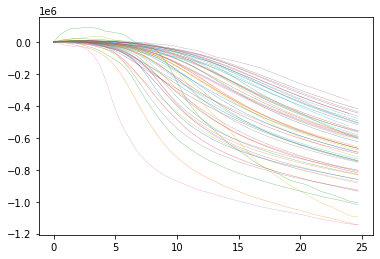

In [306]:
PT_plot = initial_processing(100,1,200)